In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import datetime as dt
from dateutil.relativedelta import relativedelta

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression


In [2]:
df = pd.read_csv('CDD/gemini_BTCUSD_1hr.csv')
df = df.reset_index()
df.columns = df.iloc[0]#['dt', 'date', 'symbol', 'open', 'high', 'low', 'close', 'volume']
df = df.iloc[1:].sort_values('Date').reset_index(drop=True)
for col in df.columns[-5:]:
    df.loc[:, col] = df[col].astype(float)

price_df = df
price_df['DT'] = pd.to_datetime(price_df.Date)
price_df['Date'] = price_df.DT.dt.date


In [3]:
price_df['Close_log'] = np.log(price_df.Close)
price_df['month'] = price_df.DT.dt.year.astype(str) + '-' + price_df.DT.dt.month.astype(str)
price_df['year'] = price_df.DT.dt.year.astype(str)

In [4]:
WINDOW_SIZES = [7, 14, 28, 56, 224, 700, 1400]

def get_increase_pct(prices, horizon=30):
    res = np.vstack([prices.shift(-i).values for i in range(horizon)])
    max_value_in_horizon = np.nanmax(res, axis=0)
    return max_value_in_horizon / prices
    

def add_ewm(df, col_name='Close'):
    columns = []
    for ws in WINDOW_SIZES:
        ewm = df[col_name].ewm(span=ws).mean()
        df.loc[:, f'ewm_{col_name}_{ws}'] = ewm
        columns.append(f'ewm_{col_name}_{ws}')
    return columns


def add_delta_pct(df, columns, col_name='Close'):
    for col in columns:
        name = f'{col}_{col_name}_delta_pct'
        df.loc[:, name] = (df[col_name] - df[col]) / df[col_name]
    return [col + '_delta_pct' for col in columns]


def add_exp_trend(df, price_col='Close'):
    xs = np.array(list(df.index))
    ys = np.log(df[price_col].values)

    model = LinearRegression()
    model.fit(xs.reshape(-1, 1), ys.reshape(-1, 1))
    preds = model.predict(xs.reshape(-1, 1))

    a = model.coef_[0]
    b = preds[0] - xs[0] * a
    df.loc[:, 'trend'] = np.exp(preds)
    return a, b


def add_linear_trend(df, price_col='Close'):
    xs = np.array(list(df.index))
    ys = df[price_col].values

    model = LinearRegression()
    model.fit(xs.reshape(-1, 1), ys.reshape(-1, 1))
    preds = model.predict(xs.reshape(-1, 1))

    a = model.coef_[0]
    b = preds[0] - xs[0] * a
    df.loc[:, 'trend'] = preds
    return a, b

In [5]:
def evaluate_indicator(df,
                    budget_per_deal=1_000,
                    indicator_col='indicator',
                    price_col='Close',
                    period=30 * 24,
                    threshold=0.01):

    deal_inds = df[indicator_col] > threshold

    indicator_budget = budget_per_deal * (df[indicator_col] + 1)
    indicator_amount = indicator_budget / df[price_col]
    indicator_amount = indicator_amount[deal_inds].mean()

    # find corrected budget ber deal
    budget = indicator_budget[deal_inds].mean() if deal_inds.sum() > 0 else budget_per_deal

    worst_amount = budget / df[price_col].max()
    best_amount = budget / df[price_col].min()
    mean_amount = budget / df[price_col].mean()
    periodic_amount = budget / df.loc[df.index[::period]][price_col].mean()

    random_inds = np.random.permutation(list(df.index[::period]))
    random_amount = budget / df.loc[random_inds][price_col].mean()

    res_df = pd.DataFrame(index = ['best_amount', 'mean_amount', 'worst_amount', 'indicator_amount'])
    res_df['value'] = [best_amount, mean_amount, worst_amount, indicator_amount]
    res_df.loc['corrected_budget', 'value'] = budget
    res_df.loc['total_budget', 'value'] = indicator_budget[deal_inds].sum()

    return res_df

# Evaluate refitting every month from 2016

In [8]:
price_df = price_df[price_df.DT.dt.year > 2015]

budget_per_deal = 1_00
indicator_col = 'indicator'
price_col = 'Close'
period = 30 * 24
threshold = 0.01

In [ ]:
period_timedelta = dt.timedelta(hours=period)

total_amounts = []
compare_df = pd.DataFrame(index = ['best_amount', 'mean_amount', 'indicator_amount', 'worst_amount', 'indicator_amt_if_trend_known'])

first_day = dt.datetime(year=2016, month=2, day=1, hour=0)
last_day = first_day + period_timedelta
while last_day < dt.datetime(year=2021, month=10, day=1, hour=0):
    period_name = str(first_day.date()) + '-' + str(last_day.date())
    # print(period_name)

    train = price_df[price_df.DT < first_day].copy()
    a, b = add_exp_trend(train)
    
    # calculate trend by past data
    test = price_df[(price_df.DT >= first_day) & (price_df.DT < last_day)].copy()
    test['trend'] = np.exp(a * np.array(list(test.index)) + b)
    add_delta_pct(test, ['trend'], price_col)

    test['indicator'] = - test.trend_Close_delta_pct
    res_df = evaluate_indicator(test.copy(),
                    budget_per_deal,
                    indicator_col,
                    price_col,
                    period,
                    threshold)
    # print(res_df)

    # if we knew correct trend
    add_exp_trend(test)
    test['indicator'] = - test.trend_Close_delta_pct
    add_delta_pct(test, ['trend'], price_col)

    res_true = evaluate_indicator(test.copy(),
                    budget_per_deal,
                    indicator_col,
                    price_col,
                    period,
                    threshold)
    
    res_df.loc['indicator_amt_if_trend_known', 'value'] = res_true.loc['indicator_amount', 'value']


    for ind in res_df.index:
        compare_df.loc[ind, period_name] = res_df.loc[ind, 'value']

    first_day += period_timedelta
    last_day += period_timedelta

    total_amount = compare_df.loc['indicator_amount'].values

total_amounts.append(total_amount)


# find threshold

In [17]:
price_df = price_df[price_df.DT.dt.year > 2015]

budget_per_deal = 1_00
indicator_col = 'indicator'
price_col = 'Close'
period = 30 * 24
# threshold = 0.31155779

In [18]:
period_timedelta = dt.timedelta(hours=period)

total_amounts = []
for threshold in np.linspace(0, 2, 200):
    compare_df = pd.DataFrame(index = ['best_amount', 'mean_amount', 'indicator_amount', 'worst_amount', 'indicator_amt_if_trend_known'])

    first_day = dt.datetime(year=2016, month=2, day=1, hour=0)
    last_day = first_day + period_timedelta
    while last_day < dt.datetime(year=2021, month=10, day=1, hour=0):
        period_name = str(first_day.date()) + '-' + str(last_day.date())
        # print(period_name)

        train = price_df[price_df.DT < first_day].copy()
        a, b = add_exp_trend(train)
        
        # calculate trend by past data
        test = price_df[(price_df.DT >= first_day) & (price_df.DT < last_day)].copy()
        test['trend'] = np.exp(a * np.array(list(test.index)) + b)
        add_delta_pct(test, ['trend'], price_col)

        test['indicator'] = - test.trend_Close_delta_pct
        res_df = evaluate_indicator(test.copy(),
                        budget_per_deal,
                        indicator_col,
                        price_col,
                        period,
                        threshold)
        # print(res_df)

        # if we knew correct trend
        add_exp_trend(test)
        test['indicator'] = - test.trend_Close_delta_pct
        add_delta_pct(test, ['trend'], price_col)

        res_true = evaluate_indicator(test.copy(),
                        budget_per_deal,
                        indicator_col,
                        price_col,
                        period,
                        threshold)
        
        res_df.loc['indicator_amt_if_trend_known', 'value'] = res_true.loc['indicator_amount', 'value']
        res_df = res_df.fillna(0)

        for ind in res_df.index:
            compare_df.loc[ind, period_name] = res_df.loc[ind, 'value']

        first_day += period_timedelta
        last_day += period_timedelta

        total_amount = compare_df.loc['indicator_amount'].values

    total_amounts.append(total_amount)
    

In [19]:
amount_mat = np.vstack(total_amounts)
amount_mat[np.isnan(amount_mat)] = 0
amount_mat.shape

(200, 68)

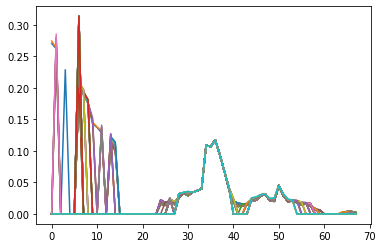

In [20]:
for thr in range(100):
    plt.plot(amount_mat[thr])

# plt.legend(thresholds[range(100)])

In [23]:
amount_mat.sum(axis=1).argmax()

0

In [28]:
amount_mat[0].sum(), amount_mat[].sum()

(3.1457388182722976, 1.0424185785122941)

In [22]:
total_amounts, amount_mat.sum(axis=1)

([array([0.2708089 , 0.26223226, 0.        , 0.22892341, 0.        ,
         0.        , 0.19936888, 0.18978499, 0.17633053, 0.14322669,
         0.13741533, 0.12862795, 0.        , 0.10846762, 0.10005509,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.01478266,
         0.0132823 , 0.01934926, 0.01505105, 0.02542538, 0.03365787,
         0.02911938, 0.03424395, 0.03677352, 0.03973375, 0.10902925,
         0.10664154, 0.11754376, 0.09427725, 0.06798509, 0.04043281,
         0.02015742, 0.01168687, 0.0130774 , 0.01456385, 0.02031481,
         0.02178741, 0.02848644, 0.03149296, 0.02120503, 0.02005127,
         0.04489663, 0.02918352, 0.0198682 , 0.02036203, 0.01803413,
         0.01386158, 0.01672552, 0.01267672, 0.00662559, 0.0057308 ,
         0.        , 0.        , 0.        , 0.        , 0.0031034 ,
         0.00318917, 0.00343554, 0.00265205]),
  array([0.27450513, 0.26369301, 0.        , 0.        ,

In [151]:
top_inds

array([62, 64, 65, 66, 67])

In [152]:
top_inds = np.argsort(total_amounts)[-5:]
thresholds[top_inds], np.array(total_amounts)[top_inds]

(array([0.31155779, 0.32160804, 0.32663317, 0.33165829, 0.33668342]),
 array([3.13335866, 3.13646205, 3.13965122, 3.14308676, 3.14573882]))

In [145]:
res_dict = dict(zip(np.linspace(0, 1, 2), total_amounts))
max(res_dict)

1.0

In [139]:
compare_df.fillna(0)

,2016-02-01-2016-03-02,2016-03-02-2016-04-01,2016-04-01-2016-05-01,2016-05-01-2016-05-31,2016-05-31-2016-06-30,2016-06-30-2016-07-30,2016-07-30-2016-08-29,2016-08-29-2016-09-28,2016-09-28-2016-10-28,2016-10-28-2016-11-27,2016-11-27-2016-12-27
best_amount,0.275442,0.274169,0.241499,0.229106,0.191564,0.161901,0.254309,0.199714,0.183499,0.151038,0.138983
mean_amount,0.251750,0.247858,0.230551,0.218003,0.157070,0.150936,0.198109,0.189593,0.176118,0.141627,0.128446
indicator_amount,0.274505,0.263315,0.000000,0.000000,0.000000,0.000000,0.199369,0.189785,0.176331,0.145827,0.138209
worst_amount,0.226439,0.237091,0.212811,0.182030,0.126815,0.142633,0.176380,0.181679,0.162400,0.135143,0.110350
indicator_amt_if_trend_known,0.274505,0.263315,0.000000,0.000000,0.000000,0.000000,0.199369,0.189785,0.176331,0.145827,0.138209
corrected_budget,101.442409,102.539322,100.000000,100.000000,100.000000,100.000000,116.056486,113.996586,110.787701,101.950545,101.228211
total_budget,202.884819,2255.865074,0.000000,0.000000,0.000000,0.000000,80543.201495,82077.541958,79767.145054,11928.213715,4352.813091


In [ ]:
year = 2019
price_col = 'Close'

train = price_df[price_df.DT.dt.year < year].copy()
test = price_df[price_df.DT.dt.year == year].copy()

In [72]:
a, b = add_exp_trend(train)
# a, b = add_linear_trend(train)
ewm_cols = add_ewm(train, price_col)
delta_cols = add_delta_pct(train, ewm_cols + ['trend'], price_col)

vol_ewm_cols = add_ewm(train, 'Volume')
vol_delta_cols = add_delta_pct(train, vol_ewm_cols, 'Volume')

In [73]:

test['trend'] = np.exp(a * test.index + b)
# test['trend'] = a * test.index + b
ewm_cols = add_ewm(test, price_col)
delta_cols = add_delta_pct(test, ewm_cols + ['trend'], price_col)

vol_ewm_cols = add_ewm(test, 'Volume')
vol_delta_cols = add_delta_pct(test, vol_ewm_cols, 'Volume')

In [74]:
train['indicator'] = - train.trend_Close_delta_pct

evaluate_indicator(train.copy(),
                    budget_per_deal=1000,
                    indicator_col='indicator',
                    price_col='Close',
                    period=30*24,
                    threshold=0.11)

,value
best_amount,0.506106
mean_amount,0.032843
indicator_amount,0.389195
worst_amount,0.006205
corrected_budget,123.287433
num_deals,12913.000000


In [76]:
df = train.copy()

deal_inds = df[indicator_col] > threshold

indicator_budget = budget_per_deal * df[indicator_col]
indicator_amount = indicator_budget / df[price_col]
indicator_amount = indicator_amount[deal_inds].mean()

# find corrected budget ber deal
budget = indicator_budget.mean()

worst_amount = budget / df[price_col].max()
best_amount = budget / df[price_col].min()
mean_amount = budget / df[price_col].mean()
periodic_amount = budget / df.loc[df.index[::period]][price_col].mean()

random_inds = np.random.permutation(list(df.index[::period]))
random_amount = budget / df.loc[random_inds][price_col].mean()

res_df = pd.DataFrame(index = ['best_amount', 'mean_amount', 'indicator_amount', 'worst_amount'])
res_df['value'] = [best_amount, mean_amount, indicator_amount, worst_amount]
res_df.loc['corrected_budget', 'value'] = budget
res_df.loc['num_deals', 'value'] = sum(deal_inds)

In [85]:
df[indicator_col] > 1.1

0        False
1        False
2        False
3        False
4        False
         ...  
28326     True
28327     True
28328     True
28329     True
28330     True
Name: indicator, Length: 28331, dtype: bool

In [87]:
indicator_budget[df[indicator_col] > 1.1]

27197    1124.558072
27198    1137.020461
27199    1181.477312
27200    1124.438541
27201    1141.350338
            ...     
28326    2740.768898
28327    2754.909345
28328    2758.404966
28329    2757.669819
28330    2741.876360
Name: indicator, Length: 1134, dtype: float64

In [78]:
indicator_budget

0          98.780513
1          98.933265
2          99.445041
3         102.614182
4          99.436523
            ...     
28326    2740.768898
28327    2754.909345
28328    2758.404966
28329    2757.669819
28330    2741.876360
Name: indicator, Length: 28331, dtype: float64

In [83]:
test['indicator'] = - test.trend_Close_delta_pct
evaluate_indicator(test.copy(),
                    initial_budget,
                    indicator_col,
                    price_col,
                    period,
                    threshold)

,amount
best,0.174374
periodic,0.082318
random,0.082318
indicator,0.149237
worst,0.042237
budget_per_deal,584.418522
hours2deal,7710.000000


In [39]:
res_df

,amount
best,1.060761
periodic,0.743686
random,0.743686
indicator,7.499670
worst,0.589014
budget_per_deal,5.800000


In [82]:
def evaluate_indicator(df, price_col='Close', indicator_col='indicator', invest_period=30*24):
    price = df[price_col]
    start_price = price.iloc[0]
    end_price = price.iloc[-1]
    min_price = price.min()
    max_price = price.max()

    ind2buy_periodic = df.index[::invest_period]
    periodic_price = price[ind2buy_periodic].mean()

    criterion_price = price[df[indicator_col] > 0].mean()

    res_df = pd.DataFrame(index = ['best', 'buy&hold', 'periodic', 'criterion', 'worst', 'end'])
    res_df['price'] = [min_price, start_price, periodic_price, criterion_price, max_price, end_price]
    res_df['gain_pct'] = (end_price / res_df.price * 100 - 100).round(1)
    return res_df

In [150]:
deal_amount = 10

trade_multiplier = -train.trend_Close_delta_pct
trade_indicators = trade_multiplier[::30]
trade_prices = np.exp(train.Close)[::30]


money_spent = deal_amount * (trade_indicators*100 + 1)
amounts_uniform = money_spent.mean() / trade_prices
amounts_by_indicator = deal_amount * (trade_indicators*100 + 1) / trade_prices

print('TRAIN')
print('Давайте покупать биток каждые 30 дней.')
print('Если покупаем ровно по 16$, на конец периода получаем ', amounts_uniform.sum())
print('Если покупаем по 10$ * (СЕКРЕТНЫЙ КОЭФФИЦИЕНТ), на конец периода получаем ', amounts_by_indicator.sum())

TRAIN
Давайте покупать биток каждые 30 дней.
Если покупаем ровно по 16$, на конец периода получаем  15.647153627048901
Если покупаем по 10$ * (СЕКРЕТНЫЙ КОЭФФИЦИЕНТ), на конец периода получаем  51.36026200786742


In [151]:
deal_amount = 10

trade_multiplier = -test.trend_Close_delta_pct
trade_indicators = trade_multiplier[::30]
trade_prices = np.exp(test.Close)[::30]


money_spent = deal_amount * (trade_indicators*100 + 1)
amounts_uniform = money_spent.mean() / trade_prices
amounts_by_indicator = deal_amount * (trade_indicators*100 + 1) / trade_prices

print('TEST')
print('Давайте покупать биток каждые 30 дней.')
print('Если покупаем ровно по 16$, на конец периода получаем ', amounts_uniform.sum())
print('Если покупаем по 10$ * (СЕКРЕТНЫЙ КОЭФФИЦИЕНТ), на конец периода получаем ', amounts_by_indicator.sum())

TEST
Давайте покупать биток каждые 30 дней.
Если покупаем ровно по 16$, на конец периода получаем  4.477912154033553
Если покупаем по 10$ * (СЕКРЕТНЫЙ КОЭФФИЦИЕНТ), на конец периода получаем  4.5452372226364


In [153]:
money_spent.mean()

152.07564689547885

In [96]:
trade_indicators

0        0.090967
30       0.092278
60       0.091013
90       0.089633
120      0.088017
           ...   
36960    0.091515
36990    0.093174
37020    0.092516
37050    0.092820
37080    0.094907
Name: trend_Close_delta_pct, Length: 1237, dtype: float64

In [90]:
10/trade_prices

0        0.040816
1        0.040816
2        0.040830
3        0.040942
4        0.040818
           ...   
37083    0.001398
37084    0.001399
37085    0.001398
37086    0.001394
37087    0.001395
Name: Close, Length: 37088, dtype: float64

In [89]:
trade_prices

0         245.00
1         245.00
2         244.92
3         244.25
4         244.99
          ...   
37083    7150.70
37084    7146.92
37085    7154.49
37086    7173.53
37087    7165.90
Name: Close, Length: 37088, dtype: float64

In [87]:
(trade_days > 0)

0.6265157639450283

<AxesSubplot:>

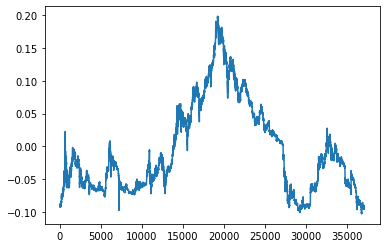

In [79]:
train.trend_Close_delta_pct.plot()

<AxesSubplot:>

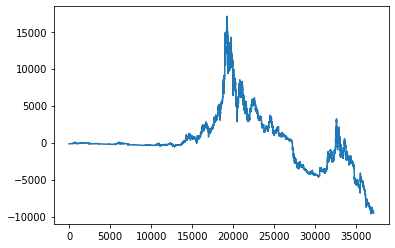

In [74]:
(np.exp(train.Close) - np.exp(train.trend)).plot()

<AxesSubplot:>

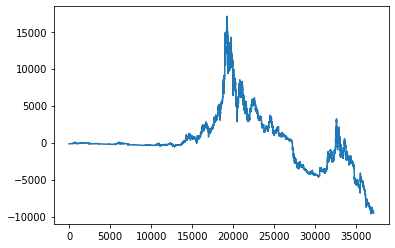

In [ ]:
(train.Close - train.exp_trend).plot()

<AxesSubplot:>

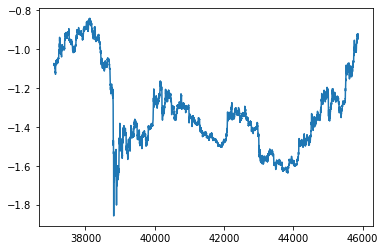

In [58]:
(test.Close - test.trend).plot()


<AxesSubplot:>

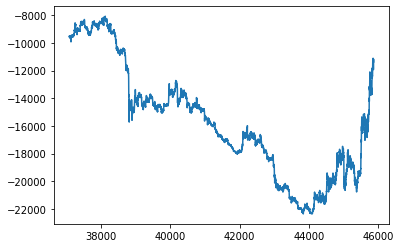

In [ ]:
(test.Close - test.exp_trend).plot()


# month vs day minima

In [77]:
names = ['Лучшая цена по месяцу в среднем', 'Средняя цена в лучший месяц', 'Лучшая цена в году']
mean_min_df = pd.DataFrame(index = names)

for year in range(2016, 2022):
    # print(year)
    slice = df[price_df.DT.dt.year == year]
    month_prices_mean = slice.groupby('month').mean()['Close']
    month_prices_min = slice.groupby('month').min()['Close']
    
    mean_min_df.loc['Средняя цена в лучший месяц', year] = month_prices_mean.min()
    mean_min_df.loc['Лучшая цена по месяцу в среднем', year] =  month_prices_min.mean()
    mean_min_df.loc['Лучшая цена в году', year] = month_prices_min.min()

mean_min_df

,2016,2017,2018,2019,2020,2021
Лучшая цена по месяцу в среднем,512.094167,2818.652500,6041.860000,6167.242500,9526.062500,36781.837000
Средняя цена в лучший месяц,401.908161,912.233649,3670.667473,3649.382336,6931.185323,34244.019234
Лучшая цена в году,355.560000,760.380000,3140.230000,3351.520000,4160.000000,29078.480000
